In [1]:
import os
from time import time
from scipy.stats import entropy
import multiprocessing as mp
import data_processing_functions as dpf
import numpy as np
import pandas as pd
import geopandas as gpd
import itertools

# visualize the catchment centroid locations
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot
from bokeh.io import output_notebook, export_png, reset_output
from bokeh.models import ColumnDataSource, LinearAxis, Range1d, Div
from bokeh.palettes import Colorblind, Sunset10
output_notebook()

from scipy.stats import lognorm, expon, kappa4, gaussian_kde
from scipy.special import kl_div, gammaln
from scipy.optimize import minimize
from scipy.integrate import quad

import jax
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde as jkde

BASE_DIR = os.getcwd()

Loading BokehJS ...

## KL Divergence Estimation

[@perez_KL_estimation] presents a method for estimatingKL divergence directly from empirical CDFs, avoiding explicit parametric or nonparametric distribution fitting. The proposed method uses intervals defined by data points to approximate probability mass, bypassing problems introduced by intermediate distribution fitting like the noise introduced by bandwidth selection in kernel density estimation (KDE), parametric distribution fitting, or discrete quantization.  However, the problem of incomplete support coverage is not resolved, requiring methodological choices that introduce additional noise to handle unsupported regions.

## Methodology

1. Draw pairs of catchments with minimum 1 year concurrent record.
2. Let the first be the target catchmnet and the second the proxy catchment.
3. Runoff in the target catchment is simulated by assuming runoff on a unit area basis is equal to the proxy catchment.
4. The estimated target catchment flow is given by $f(x) = \frac{A_\text{target}}{A_\text{proxy}} * x_\text{proxy}$.
5. Let $Q(x)$ represent the runoff distribution of the proxy catchment,
6. $Q(x)$ represents the approximation of the "ground truth" distribution $P(x)$ of the target runoff.
7. Fit a distribution to $X_\text{proxy}$ by Kernel Density Estimation.
8. For the KDE, set the bandwidth using "Scott's Rule", given by $\sigma_\text{target} \cdot n^{-1/5}$ where n is the sample size and $\sigma_\text{target}$ is the sample standard deviation.
9. Set a quantization of 6 bits and compute the cdf of the t

## Problem Cases

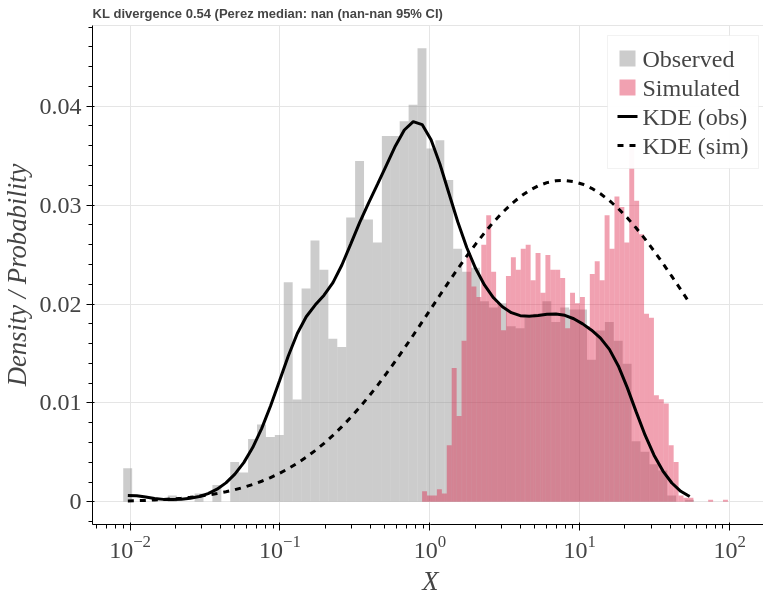

The plot above shows a common issue with using KDE to estimate KL divergence where the approximation $Q(x)$ does not provide support coverage of $P(x)$. Mismatch combined with steep cutoffs means the bandwidth is increased until $Q > 0$ for all $P > 0$. To provide support coverage to the far left of the target distribution requires smoothing that represents significant distortion noise, diminishing the divergence.  (what is the concurrent period?)  The KL divergence in this case is small compared to the distortion rate due to KDE fit.  

Another point about this is the precision.  The quantization dictates how much of the precision is retained from the original signal.  If the level of precision is not justifiable from measurement uncertainty, what does the KL divergence, or any measure from the class of f-divergences, represent?   

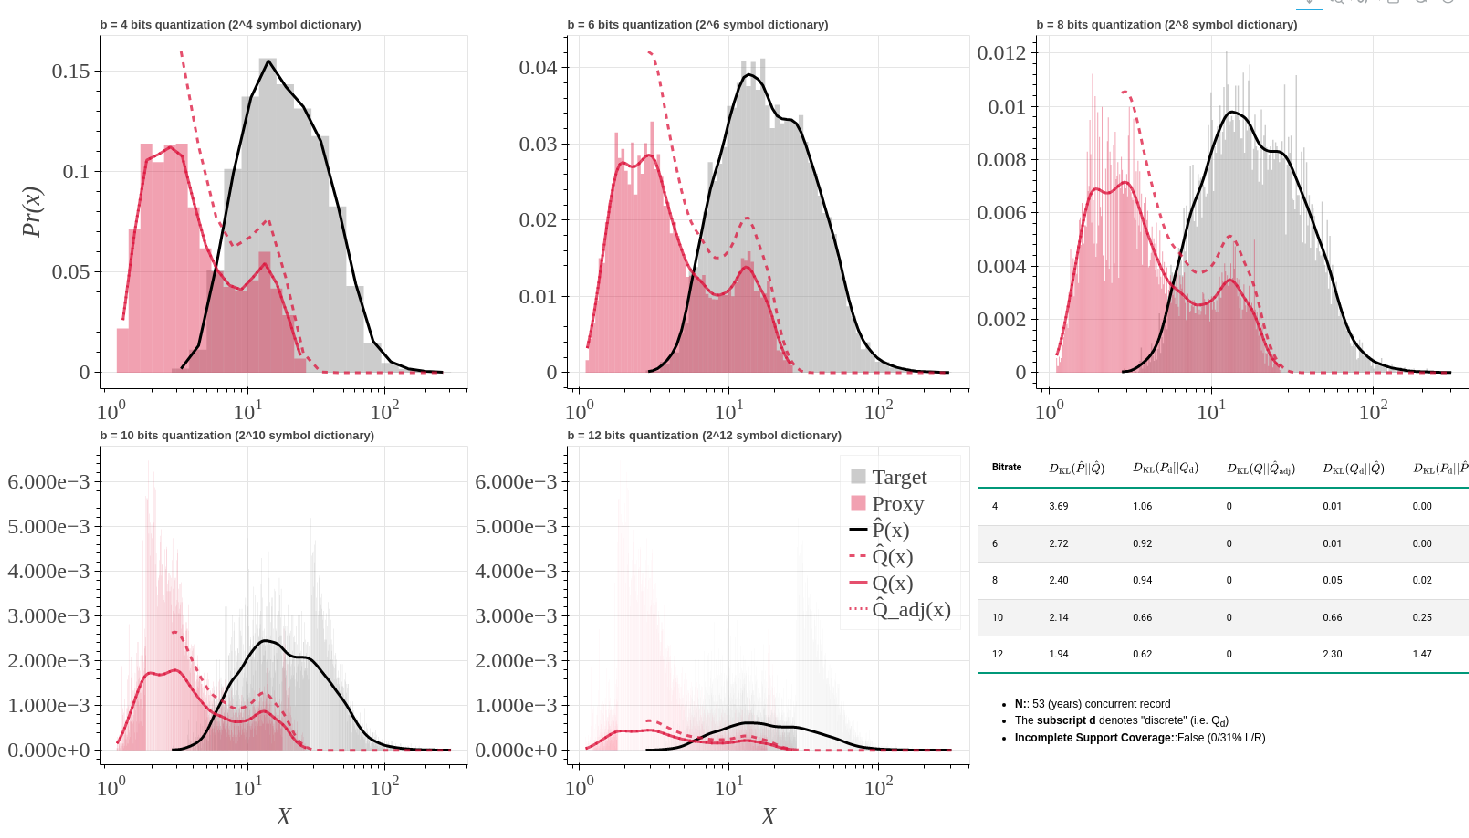

In the figure above, note how the $D_\text{KL}(P_d||Q_d)$ decreases with increasing bitrate. This represents a lack of robustness in the estimate.

If we want to compare the KL divergence across *discrete* bitrates, we must account for how much information is added by the prior.  We can't simply add a constant Dirichlet prior of $\text{Dirichlet}(\alpha + n_i)$ since this adds $N\cdot \alpha$ total counts to the distribution.  Dividing by the number of bins regularizes the information added (the total number of counts).  One effect of this adjustment is that the prior is now much smaller, which tends to cause heavier penalties where $q_i$ was otherwise zero.  However this is offset by the probabilities being spread out more anyway.

If the ultimate goal is to represent floating point precision data losslessly. then we should pick a precision or a quantization that aligns with something practical.  

In [2]:
# import streamflow record timeseries
attributes_filename = 'BCUB_watershed_attributes_updated.csv'
attributes_fpath = os.path.join(os.getcwd(), 'data', attributes_filename)
attr_df = pd.read_csv(attributes_fpath)
attr_df.columns = [e.lower() for e in attr_df.columns]
# df.columns
filtered_stns = sorted(list(set(attr_df['official_id'].values)))

# load the attributes file with catchment geometries
geom_file = 'BCUB_watershed_attributes_updated.geojson'
bcub_gdf = gpd.read_file(os.path.join(os.getcwd(), 'data', geom_file))
bcub_gdf.columns = [c.lower() for c in bcub_gdf.columns]

In [3]:
def compute_kl_divergence(p, q):
    # compute DKL(Q||Q_post), or the divergence
    # of the posterior from the likelihood due to the prior
    mask = (q > 0) & (p > 0)
    result = np.zeros_like(p)
    result[mask] = p[mask] * np.log2(p[mask] / q[mask])
    return np.nansum(result[mask])

## Pairwise Processing



In [4]:
# create a new output filename 
attributes_filename = 'BCUB_watershed_attributes_updated.csv'
attributes_fpath = os.path.join(os.getcwd(), 'data', attributes_filename)
attr_df = pd.read_csv(attributes_fpath)
attr_df.columns = [e.lower() for e in attr_df.columns]
# df.columns
filtered_stns = sorted(list(set(attr_df['official_id'].values)))

In [5]:
# generate all combinations of pairs of station ids
id_pairs = list(itertools.combinations(filtered_stns, 2))
print(f' There are {len(id_pairs)} unique pairings in the dataset')
# shuffle the pairs to make testing smaller batches more robust
np.random.seed(42)
np.random.shuffle(id_pairs)

 There are 877150 unique pairings in the dataset


In [6]:
# set a revision date for the results output file
revision_date = '20241125'

# how many pairs to compute in each batch
batch_size = 5000
# batch_size = 10

# # what percentage of 365 observations in a year counts as a "complete" year
# completeness_threshold = 0.9
# min_observations = 365 * 0.9

# station pairs with less than min_years concurrent years of data are excluded (for concurrent analysis),
# stations with less than min_years are excluded (for non-concurrent analysis),
min_years = 1 #[2, 3, 4, 5, 10]

# a prior is applied to q in the form of a uniform array of 10**c pseudo-counts "c"
# this prior is used to test the effect of the choice of prior on the model
pseudo_counts = [-5, -4, -3, -2, -1, -0.5, -0.2, -0.1, 0, 0.1, 0.2, 0.5, 1, 2, 3, 4, 5]

# set the number of quantization levels to test, equal to 2^bitrate
bitrates = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Preload all records into a dictionary for fast lookup
records_dict = bcub_gdf.copy().set_index('official_id').to_dict(orient='index')

In [7]:
temp_dir = os.path.join(os.getcwd(), 'data/', 'temp')
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

In [8]:
def input_batch_generator(df, id_pairs_filtered, min_years, use_partial_counts, bitrates):
    batch_inputs = []
    for proxy, target in id_pairs_filtered:
        
        proxy_dict = records_dict.get(proxy, {})
        target_dict = records_dict.get(target, {})

        proxy_dict['official_id'] = proxy
        target_dict['official_id'] = target

        assert 'geometry' in proxy_dict.keys(), proxy_dict.keys()
        assert 'geometry' in target_dict.keys(), target_dict.keys()
        
        batch = [proxy_dict, target_dict, min_years, bitrates]
        batch_inputs.append(batch)
    return batch_inputs

In [9]:
def compute_hist_and_log_edges(x, n_bins):
    min_log_val = np.log10(np.nanmin(x))
    max_log_val = np.log10(np.nanmax(x))

    # set the bin edges to be evenly spaced between the
    # observed range of the proxy/donor series
    log_bin_edges = np.linspace(
        min_log_val,
        max_log_val,
        n_bins + 1,
    ).flatten()
    bin_edges = [10**e for e in log_bin_edges]
    log_counts, _ = np.histogram(x, bins=bin_edges, density=False)
    freqs = log_counts / sum(log_counts)
    assert abs(sum(freqs) - 1) < 0.0001
    return freqs, bin_edges 

In [10]:
def plot_cdf_kde_histogram(hist_targ, hist_proxy, edges_target, edges_proxy, kde_target, kde_proxy_og, kde_proxy_approx, kde_proxy_adj, 
                                    kde_kld, kde_proxy_bias, kde_adj_proxy_bias, kde_target_bias, n_years, bitrate):
    """
    Plot and save the empirical CDF, KDE fit, and histogram using Bokeh.
    Args:
        x: 1D array of x values (for KDE and CDF).
        cdf: Empirical CDF values corresponding to x.
        kde: KDE fit values corresponding to x.
        hist: Histogram heights.
        bins: Bin edges for the histogram.
        output_path: Path to save the PNG output.
    """
    
    bin_midpts_target = (np.array(edges_target[:-1]) + np.array(edges_target[1:])) / 2

    # Create the figure
    p = figure(width=800, height=600,
        title=f"b = {bitrate} bits quantization (2^{bitrate} symbol dictionary)",
              x_axis_type='log')
    if bitrate > 8:
        p.xaxis.axis_label = "X" 
    if (bitrate == 4) | (bitrate == 10):
        p.yaxis.axis_label = "Pr(x)"

    # Add histogram (muted grey with alpha)
    p.quad(top=hist_targ, bottom=0, left=edges_target[:-1], right=edges_target[1:],
           fill_color="grey", fill_alpha=0.4, line_color=None, legend_label="Obs.")
    p.quad(top=hist_proxy, bottom=0, left=edges_proxy[:-1], right=edges_proxy[1:],
           fill_color="crimson", fill_alpha=0.4, line_color=None, legend_label="Sim.")

    # Add KDE lines series 
    p.line(bin_midpts_target, kde_target, line_width=3, line_color="black", line_dash='solid', legend_label="P̂(x)",)
    p.line(bin_midpts_target, kde_proxy_approx, line_width=3, alpha=0.75,
           line_color="crimson", line_dash='dashed', legend_label="Q̂(x)",)

    # Add original proxy PDF
    bin_midpts_proxy = (np.array(edges_proxy[:-1]) + np.array(edges_proxy[1:])) / 2
    p.line(bin_midpts_proxy, kde_proxy_og, line_width=3, alpha=0.75, 
           line_dash='solid', line_color="crimson", legend_label="Q(x)",)
    p.line(bin_midpts_proxy, kde_proxy_adj, line_width=3, alpha=0.75, 
           line_dash='dotted', line_color="crimson", legend_label="Q̂_adj(x)",)

    # Style the legend
    p.legend.location = "top_right"
    # p.legend.title = "Legend"
    p = dpf.format_fig_fonts(p)

    return p
    

In [11]:
def compute_missing_coverage_probability_mass(x1, x2):
    min_x2, max_x2 = np.nanmin(x2), np.nanmax(x2)
    missing_left = np.where(x1 < min_x2, 1, 0)
    missing_right = np.where(x1 > max_x2, 1, 0)
    left_mass = np.nansum(missing_left) / len(x1)
    right_mass = np.nansum(missing_right) / len(x1)
    return left_mass, right_mass    

In [12]:
def compute_discrete_kl_divergence(x1, x2, b, prior=1):
    """
    X1 is observed.
    X2 is simulated.
    
    We want to know the extra description, the memory overhead, 
    resulting from mis-estimated frequencies of an approximate Q
    when the "ground truth" is P.
    The ground truth P should reflect the binning "optimized for P", 
    so it should represent the "a posteriori" frequencies.
    So then the simulated values should be binned according to 
    a version of P where two edge bins are reserved for out-of-range 
    simulated values.
    """
    df = pd.DataFrame()
    P_hist, P_edges = compute_hist_and_log_edges(x2, n_bins=int(2**b - 2))
    # Q_hist, Q_edges = compute_hist_and_log_edges(x2, n_bins=int(2**b - 2))
    
    # digitize the target based on the proxy edges
    df['obs_digitized'] = np.digitize(x1, P_edges)
    # digitize the proxy based on the "ground truth" edges
    # to see how the "proxy model" estimates the "true" frequences
    df['sim_digitized'] = np.digitize(x2, P_edges)

    # count the occurrences of each quantized value
    # the "simulated" series is the proxy/donor series
    # and the "observed" series is the target location
    obs_count_df = df.groupby('obs_digitized').count()
    sim_count_df = df.groupby('sim_digitized').count()

    sim_col = sim_count_df.columns[0]
    obs_col = obs_count_df.columns[0]

    count_df = pd.DataFrame(index=range(2**b))
    count_df['obs'] = 0
    # divide the prior by the bitrate so that the same information is added across bitrates
    count_df['sim'] = prior / 2**b

    # note that the labels here don't matter
    count_df['obs'] += obs_count_df.iloc[:, 0].reindex(count_df.index, fill_value=0)
    count_df['sim'] += sim_count_df.iloc[:, 0].reindex(count_df.index, fill_value=0)
    
    p = (count_df['obs'] / len(x1)).values
    q = (count_df['sim'] / len(x2)).values
    assert np.all(q > 0), q
    kld_discrete = compute_kl_divergence(p, q)
    return kld_discrete
    

In [13]:
def save_gridplot(plots, output_path):
    layout = gridplot(plots, ncols=3, width=550, height=450)
    # Save as PNG
    try:
        export_png(layout, filename=output_path)
    finally:
        # Clean up Bokeh output state
        reset_output()
    print(f"Plot saved to {output_path}")

In [14]:
def vectorized_kde_integration(kde_fit_object, edges):
    integrate_cdf = jax.vmap(lambda xi: kde_fit_object.integrate_box_1d(-jnp.inf, jnp.log10(xi)))
    cdf_values = integrate_cdf(np.array(edges))
    pmf_values = np.diff(cdf_values)
    return pmf_values


In [15]:
def adjust_kde_bandwidth(data, smoothing_factor=1.01, adjusted_bw='scott'):
    """
    Adjust the bandwidth of a Gaussian KDE by scaling Scott's bandwidth.

    Args:
        data: 1D array of data points for KDE.
        factor: Scaling factor for the bandwidth (default is 1.0, i.e., no adjustment).

    Returns:
        proxy_kde: KDE object with adjusted bandwidth.
    """
    # Compute Scott's bandwidth
    n = data.size
    if adjusted_bw == 'scott':
        bw = jnp.std(data) * n**(-1 / 5)  # Scott's rule
    else:
        bw = adjusted_bw

    # Scale the bandwidth by the smoothing factor
    return smoothing_factor * bw

In [21]:
def fit_KDE_and_check_min_Qx(kde_fit, x1, x2, bin_edges, adjusted_bw='scott', min_q_allowed=1e-7, modified_bw=False):
    """
    Check that the smallest x1 (target value) probability mass evaluated
    on the proxy fit is greater than some minimum threshold 
    (the purpose is to avoid dividing by zero later on -- just setting != 0 is not enough
    use KDE to estimate the pdf for the proxy / simulated values
    """
    pmf = vectorized_kde_integration(kde_fit, bin_edges)

    # min_probability_mass = np.nanmin(np.diff(np.array([kde_proxy_fit.integrate_box_1d(-np.inf, np.log10(xi)) for xi in edges_target])))
    min_probability_mass = np.nanmin(pmf)
    log_x2 = np.log10(x2)
    if adjusted_bw == 'scott':
        max_bw_exceeded = False
    else:
        max_bw_exceeded = adjusted_bw > 5 * np.std(log_x2)
    # recursively change the bandwidth until the smallest probability is 
    # something we deem acceptable--this smooths the distribution
    if max_bw_exceeded:
        print('    MAX BANDWIDTH EXCEEDED.')
        return kde_fit, max_bw_exceeded
        
    if (min_probability_mass == 0):
        adj_bw = adjust_kde_bandwidth(log_x2, adjusted_bw=adjusted_bw)
        # print(f'    min probability mass = {100*min_probability_mass:.3f}% adjusted bw to {adj_bw:.2f}')
        kde_fit = jkde(log_x2, bw_method=adj_bw)
        
        # recursively adjust the bandwidth
        return fit_KDE_and_check_min_Qx(
            # x1, x2, adjusted_bw=adj_bw, underspecified_kde=True
            kde_fit, x1, x2, bin_edges, adjusted_bw=adj_bw, modified_bw=True
        )
    return kde_fit, max_bw_exceeded
    

In [22]:
def kl_divergence_convergence(proxy, target, x1, x2, n_complete_years, bitrates,
                              n_resamples=100, epsilon=1e-10, n_bins=64):
    """
    Vectorized estimation of KL divergence convergence using bootstrap resampling.

    Parameters:
    - x1, x2: Arrays of observations from target (posteriori observed) and proxy (simulated)
    - n_resamples: Number of bootstrap resamples.

    Returns:
    - KL divergence estimate D_KL(P||Q).
    """
    n = len(x1)
    print(f'N={n} samples, ({n_complete_years:.1f} years)')
    t0 = time()
    
    # use KDE to estimate the pdf for the target / true values
    log_x1 = jnp.log10(x1)
    kde_target = jkde(log_x1)
    t1 = time()
    
    # use KDE to estimate the pdf for the proxy / simulated values
    log_x2 = jnp.log10(x2) 
    # compute the baseline (unadjusted) proxy KDE PDF
    kde_proxy_baseline = jkde(log_x2)
    t2 = time()

    result = {}
    result['n_concurrent_years'] = n_complete_years
    # compute the probability mass out of range (left and right separately)
    missing_support_left, missing_support_right = compute_missing_coverage_probability_mass(x1, x2)
    result['missing_support_coverage_PMF_left'] = missing_support_left
    result['missing_support_coverage_PMF_right'] = missing_support_right
    underspecified_kde = False
    if missing_support_left + missing_support_right > 0.0001:
        underspecified_kde = True
    result['underspecified_kde'] = underspecified_kde
    plots = []
    kde_results = []
    for b in bitrates:
        n_bins = int(2**b)
        # compute discrete distributions on 2**b - 2 bins so it is comparable
        # with the discrete KL divergence computation where we reserve 2 bins at the extremes
        # for simulations out of range of the "ground truth" distribution
        hist_target, edges_target = compute_hist_and_log_edges(x1, n_bins)
        hist_proxy, edges_proxy = compute_hist_and_log_edges(x2, n_bins)

        # compute the proxy KDE PDF with adjusted bandwidth 
        # to provide support coverage of target 
        kde_proxy_approx, max_bw_exceeded = fit_KDE_and_check_min_Qx(kde_proxy_baseline, x1, x2, edges_target)

        # compute the "ground truth" PMF 
        # --> this is P(x)
        kde_target_pmf = vectorized_kde_integration(kde_target, edges_target)
        kde_target_pmf /= kde_target_pmf
        
        # compute the "baseline" proxy/observed PMF using the PROXY edges
        kde_proxy_pmf_baseline = vectorized_kde_integration(kde_proxy_baseline, edges_proxy)
        kde_proxy_pmf_baseline /= kde_proxy_pmf_baseline

        # compute the "approximate" PMF from the adjusted fit on the TARGET edges
        # --> this is Q(x)
        if max_bw_exceeded:
            kde_proxy_pmf_approx = np.full(n_bins, 1/n_bins)
        else:
            kde_proxy_pmf_approx = vectorized_kde_integration(kde_proxy_approx, edges_target)

        # do not normalize the KDE since it would transfer out of range 
        # probability mass into the target range 
        # kde_target = kde_target / np.nansum(kde_target) 
        # kde_proxy = kde_proxy / np.nansum(kde_proxy) 
        
        # compute KL divergence between the observed (target, P(x)) and simulated (proxy, Q(x)) 
        # THE PMFs COMPARED HERE MUST USE THE SAME EDGES
        kde_kl_divergence = compute_kl_divergence(kde_target_pmf, kde_proxy_pmf_approx) 
        result[f'{b}_bit_kld_kde'] = kde_kl_divergence
    
        # compute the "approximate" PMF from the ADJUSTED fit on the PROXY edges
        # this measures how much bias was added to the PMF in order to 
        # provide complete support coverage to P(x)
        # kde_proxy_pmf_adj = np.diff(np.array([kde_proxy_approx.integrate_box_1d(-np.inf, np.log10(xi)) for xi in edges_proxy]))
        kde_proxy_pmf_adj = vectorized_kde_integration(kde_proxy_approx, edges_proxy)
        proxy_adjusted_kde_bias = compute_kl_divergence(kde_proxy_pmf_baseline, kde_proxy_pmf_adj)
        if abs(proxy_adjusted_kde_bias) < 0.0001:
            proxy_adjusted_kde_bias = 0
        assert proxy_adjusted_kde_bias >= 0, "Adjusted proxy KDE bias DKL is negative"
        result[f'{b}_bit_kde_adjusted_proxy_bias'] = proxy_adjusted_kde_bias

        # compute the representation bias from the discrete to baseline kde
        kde_proxy_bias = compute_kl_divergence(hist_proxy, kde_proxy_pmf_baseline)
        result[f'{b}_bit_kde_baseline_proxy_bias'] = kde_proxy_bias
        kde_target_bias = compute_kl_divergence(hist_target, kde_target_pmf)
        result[f'{b}_bit_kde_baseline_target_bias'] = kde_target_bias

        kld_discrete = compute_discrete_kl_divergence(x1, x2, b)

        kde_results.append([b, round(kde_kl_divergence, 2), round(kld_discrete, 2), round(proxy_adjusted_kde_bias, 2), round(kde_proxy_bias, 2), round(kde_target_bias, 2)])

        # don't plot above 10 bits as it doesn't show anything meaningful
        if b < 12:
            # Compute median and confidence intervals
            plot = plot_cdf_kde_histogram(hist_target, hist_proxy, edges_target, edges_proxy, 
                                            kde_target_pmf, kde_proxy_pmf_baseline, kde_proxy_pmf_approx, kde_proxy_pmf_adj,
                                            kde_kl_divergence, kde_proxy_bias, proxy_adjusted_kde_bias, kde_target_bias, 
                                            n_complete_years, b)
            if b < 10:
                plot.legend.visible = False
            plot.legend.background_fill_alpha = 0.5
            plots.append(plot)
        print(f'    {b} bits KDE KLD = {kde_kl_divergence:.2f} bits/sample, proxy_baseline/proxy_adj/target bias: {kde_proxy_bias:.2f}/{proxy_adjusted_kde_bias:.2f}/{kde_target_bias:.2f} bits/sample ({missing_support_left:.2f}/{missing_support_right:.2f} L/R missing support)')
    # print(asdf)
    result_df = pd.DataFrame(kde_results, columns=['Bitrate', r'$$D_\text{KL}(\hat P||\hat Q)$$', r'$$D_\text{KL}(P_\text{d}|| Q_\text{d})$$', r'$$D_\text{KL}(Q||\hat Q_\text{adj})$$', r'$$D_\text{KL}(Q_\text{d}||\hat Q)$$', r'$$D_\text{KL}(P_\text{d}|| \hat P)$$'])
    html_table = result_df.to_html(index=False, border=0, classes="styled-table")
    styled_html = f"{dpf.table_style}{html_table}"
    styled_html += f"<h3>Notes:</h3><ol><li><b>N</b>: {n_complete_years} (years) concurrent record</li>"
    styled_html += f'<li>The <b>subscript d</b> denotes "discrete" (i.e. Q<sub>d</sub>)</li>'
    styled_html += f"<li><b>Incomplete Support Coverage:</b>:{underspecified_kde} ({100*missing_support_left:.0f}/{100*missing_support_right:.0f}% L/R)</li></ol>"
    t4 = time()
    
    print(f'X1 KDE fit:{t1-t0:.1f}s, X2 base KDE fit:{t2-t1:.1f}s, X2 adj. compute KLDs:{t4-t2:.1f}s')

    # Render in a Bokeh Div
    result_div = Div(text=styled_html, width=400)
    plots.append(result_div)
    output_path = f'KDE_fit_plots/sim_{target}_using_{proxy}.png'
    save_gridplot(plots, output_path)
    return result

In [23]:
def process_batch(inputs):    
    proxy, target, min_concurrent_years, bitrates = inputs
    
    proxy_id, target_id = proxy['official_id'], target['official_id']

    # create a result dict object for tracking results of the batch comparison
    result = {
        "proxy": proxy_id,
        "target": target_id,
        "min_concurrent_years": min_concurrent_years,
    }
    station_info = {"proxy": proxy, "target": target}

    # check if the polygons are nested
    result["nested_catchments"] = dpf.check_if_nested(proxy, target)

    # for stn in pair:
    proxy = dpf.Station(station_info["proxy"])
    target = dpf.Station(station_info["target"])
    target.ln_pdf_label = f'{target.id}_sim_lognorm_pdf'
    target.ln_cdf_label = f'{target.id}_sim_lognorm_cdf'
    target.expon_pdf_label = f'{target.id}_sim_expon_pdf'
    target.expon_cdf_label = f'{target.id}_sim_expon_cdf'

    # compute spatial distance
    p1, p2 = (
        station_info["proxy"]["geometry"].centroid,
        station_info["target"]["geometry"].centroid,
    )
    # compute the distance between catchment centroids (km)
    centroid_distance = p1.distance(p2) / 1000
    result["centroid_distance"] = round(centroid_distance, 2)
    if centroid_distance > 1000:
        return None

    if np.isnan(target.drainage_area_km2):
        raise ValueError(f"No drainage area for {target_id}")
    if np.isnan(proxy.drainage_area_km2):
        raise ValueError(f"No drainage area for {proxy_id}")

    # Retrieve the data for both stations
    # this is all data, including non-concurrent
    adf = dpf.retrieve_nonconcurrent_data(proxy_id, target_id)

    assert ~adf.empty, "No data returned."

    for stn in [proxy, target]:
        adf = dpf.transform_and_jitter(adf, stn)

    # simulate flow at the target based on equal unit area runoff scaling
    adf[target.sim_label] = adf[proxy.id] * (
        target.drainage_area_km2 / proxy.drainage_area_km2
    )

    # filter for the concurrent data
    df = adf.copy().dropna(subset=[proxy_id, target_id], how="any")
    result["num_concurrent_obs"] = len(df)
    
    if df.empty:
        num_complete_concurrent_years = 0
    else:
        df.reset_index(inplace=True)
        num_complete_concurrent_years = dpf.count_complete_years(df, 'time', proxy_id)
        
    counts = df[[proxy_id, target_id]].count(axis=0)
    counts = adf.count(axis=0)
    proxy.n_obs, target.n_obs = counts[proxy_id], counts[target_id]
    
    result[f"proxy_n_obs"] = proxy.n_obs
    result[f"target_n_obs"] = target.n_obs
    result[f"proxy_frac_concurrent"] = len(df) / proxy.n_obs
    result[f"target_frac_concurrent"] = len(df) / target.n_obs

    if (counts[proxy_id] == 0) or (counts[target_id] == 0):
        print(f"   Zero observations.  Skipping.")
        return None

    # process the PMFs and divergences for concurrent data 
    # using a range of uniform priors via pseudo counts  
    if num_complete_concurrent_years > min_concurrent_years:
        # df is concurrent data, so the results
        # are updating concurrent data here    
        df.dropna(subset=[target.sim_label, target.id], inplace=True)
        # x1 is the observed, x2 is the simulated
        x1, x2 = df[target.id].values, df[target.sim_label].values
        # fit kde to proxy values
        pair_result = kl_divergence_convergence(proxy.id, target.id, x1, x2, num_complete_concurrent_years, bitrates)
        result.update(pair_result)
    
    return result

In [24]:
# the 'process' variable is here so jupyter doesn't go computing 
# a million rows per iteration when the book is built for pushing to github pages.

process = True
partial_counts = False
bitrates = [4, 6, 8, 10, 12]
if process:
    print(f'Processing empirical CDF pairs (partial counts={partial_counts})')
    results_fname = f'KL_kde_fits_{revision_date}.csv'

    out_fpath = os.path.join('data/', 'nonparametric_divergence_test', results_fname)

    n_batches = max(len(id_pairs) // batch_size, 1)
    batches = np.array_split(np.array(id_pairs, dtype=object), n_batches)
    n_pairs = len(id_pairs)
    print(f"    Processing {n_pairs} pairs in {n_batches} batches.")
    batch_no = 1
    batch_files = []
    t0 = time()
    # error_df = error_model_df[error_model_df['bitrate'] == bitrate].copy()
    for batch_ids in batches:
        print(f'Starting batch {batch_no}/{len(batches)} processing.')
        batch_fname = results_fname.replace('.csv', f'_batch_{batch_no:04d}.csv')
        batch_output_fpath = os.path.join(temp_dir, batch_fname)
        print(batch_output_fpath)
        if os.path.exists(batch_output_fpath):
            batch_files.append(batch_output_fpath)
            batch_no += 1
        #     continue
        
        # define the input array for multiprocessing
        inputs = input_batch_generator(bcub_gdf, batch_ids, min_years, partial_counts, bitrates)

        # with mp.Pool(20) as pool:
        #     results = pool.map(process_batch, inputs)
        #     results = [r for r in results if r is not None]
        results = []
        for inp in inputs:
            res = process_batch(inp)
            if res is not None:
                results.append(res)

        batch_result = pd.DataFrame(results)
        # print(batch_result)
        # print(asdf)
        if batch_result.empty:
            print('Empty batch.  Skipping')
        else:
            batch_result.to_csv(batch_output_fpath, index=False)
            print(f"    Saved {len(batch_result)} new results to file.")
        
        batch_files.append(batch_output_fpath)
        t2 = time()
        print(f'    Processed {len(batch_ids)} pairs in {t2 - t0:.1f} seconds')
        batch_no += 1
        
    print(f'    Concatenating {len(batch_files)} batch files.')
    if len(batch_files) > 0:
        all_results = pd.concat([pd.read_csv(f, engine='pyarrow') for f in batch_files], axis=0)
        all_results.to_csv(out_fpath, index=False)
        if os.path.exists(out_fpath):
            for f in batch_files:
                os.remove(f)
        print(f'    Wrote {len(all_results)} results to {out_fpath}')
    else:
        print('    No new results to write to file.')

Processing empirical CDF pairs (partial counts=False)
    Processing 877150 pairs in 175 batches.
Starting batch 1/175 processing.
/home/danbot2/code_5820/24/divergence_measures/docs/notebooks/data/temp/KL_kde_fits_20241125_batch_0001.csv
N=5557 samples, (2.0 years)
    4 bits KDE KLD = 0.34 bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.00/0.03 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 0.35 bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.00/0.05 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 0.35 bits/sample, proxy_baseline/proxy_adj/target bias: 0.09/0.00/0.12 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 0.35 bits/sample, proxy_baseline/proxy_adj/target bias: 0.52/0.00/0.88 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 0.35 bits/sample, proxy_baseline/proxy_adj/target bias: 2.38/0.00/2.87 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. comp

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.02/0.01 bits/sample (0.47/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.02/0.04 bits/sample (0.47/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.06/0.03/0.24 bits/sample (0.47/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.30/0.03/1.05 bits/sample (0.47/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.60/0.03/2.69 bits/sample (0.47/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:12.9s
Plot saved to KDE_fit_plots/sim_08LG068_using_08GA072.png
N=4290 samples, (11.0 years)
    4 bits KDE KLD = 0.05 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.01 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 0.05 bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.00/0.02 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 0.05 bits/sample, proxy_baseline/proxy_adj/target bias: 0.16/0.00/0.24 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 0.05 bits/sample, proxy_baseline/proxy_adj/target bias: 0.92/0.00/1.48 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 0.05 bits/sample, proxy_baseline/proxy_adj/target bias: 2.57/0.00/3.36 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE 

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.09/0.07/0.41 bits/sample (0.46/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.13/0.09/0.92 bits/sample (0.46/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.27/0.09/1.78 bits/sample (0.46/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.04/0.09/3.29 bits/sample (0.46/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 2.83/0.09/5.19 bits/sample (0.46/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:11.7s
Plot saved to KDE_fit_plots/sim_12197110_using_08GE002.png
N=4018 samples, (8.0 years)
    4 bits KDE KLD = 0.89 bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.00/0.00 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 0.90 bits/sample, proxy_baseline/proxy_adj/target bias: 0.28/0.00/0.01 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 0.90 bits/sample, proxy_baseline/proxy_adj/target bias: 0.85/0.00/0.06 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 0.90 bits/sample, proxy_baseline/proxy_adj/target bias: 1.74/0.00/0.43 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 0.90 bits/sample, proxy_baseline/proxy_adj/target bias: 3.21/0.01/1.78 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE 

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.02/0.03 bits/sample (0.89/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.07/0.03/0.05 bits/sample (0.89/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.05/0.03/0.18 bits/sample (0.89/0.00 L/R missing support)
    10 bits KDE KLD = 44.92 bits/sample, proxy_baseline/proxy_adj/target bias: 3.01/0.03/1.03 bits/sample (0.89/0.00 L/R missing support)
    12 bits KDE KLD = 44.92 bits/sample, proxy_baseline/proxy_adj/target bias: 5.01/0.03/2.88 bits/sample (0.89/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:16.9s
Plot saved to KDE_fit_plots/sim_12302000_using_12191800.png
N=3124 samples, (8.0 years)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.02/0.05 bits/sample (0.29/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.06/0.04/1.00 bits/sample (0.29/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.23/0.04/2.67 bits/sample (0.29/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.65/0.04/4.65 bits/sample (0.29/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 3.62/0.04/6.65 bits/sample (0.29/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:12.5s
Plot saved to KDE_fit_plots/sim_08LG055_using_08KC003.png
N=10659 samples, (26.0 years)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.00/0.09/0.01 bits/sample (0.03/0.03 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.13/0.02 bits/sample (0.03/0.03 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.26/0.14/0.05 bits/sample (0.03/0.03 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.94/0.14/0.20 bits/sample (0.03/0.03 L/R missing support)
    12 bits KDE KLD = 1.62 bits/sample, proxy_baseline/proxy_adj/target bias: 2.58/0.16/0.88 bits/sample (0.03/0.03 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:20.0s
Plot saved to KDE_fit_plots/sim_12392155_using_12330000.png
N=19499 samples, (47.0 years)
    4 bits KDE KLD = 1.17 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.18/0.00 bits/sample (0.00/0.29 L/R missing support)
    6 bits KDE KLD = 1.11 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.21/0.00 bits/sample (0.00/0.29 L/R missing support)
    8 bits KDE KLD = 1.04 bits/sample, proxy_baseline/proxy_adj/target bias: 0.04/0.25/0.02 bits/sample (0.00/0.29 L/R missing support)
    10 bits KDE KLD = 0.99 bits/sample, proxy_baseline/proxy_adj/target bias: 0.45/0.29/0.19 bits/sample (0.00/0.29 L/R missing support)
    12 bits KDE KLD = 0.95

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.00/0.01 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.06/0.00/0.05 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.15/0.00/0.56 bits/sample (0.38/0.00 L/R missing support)
    10 bits KDE KLD = 9.19 bits/sample, proxy_baseline/proxy_adj/target bias: 0.95/0.00/2.27 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 2.93/0.00/4.27 bits/sample (0.38/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:7.8s
Plot saved to KDE_fit_plots/sim_12153000_using_08KH013.png
N=3176 samples, (2.0 years)
    4 bits KDE KLD = 1.00 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.06 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 1.01 bits/sample, proxy_baseline/proxy_adj/target bias: 0.07/0.00/0.08 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 1.01 bits/sample, proxy_baseline/proxy_adj/target bias: 0.60/0.00/0.17 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 1.01 bits/sample, proxy_baseline/proxy_adj/target bias: 2.08/0.00/0.78 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 1.01 bits/sample, proxy_baseline/proxy_adj/target bias: 4.07/0.00/2.49 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE f

E1207 17:49:06.537919 2255281 hlo_lexer.cc:443] Failed to parse int literal: 78715656595445672647


    10 bits KDE KLD = 0.08 bits/sample, proxy_baseline/proxy_adj/target bias: 1.18/0.00/3.12 bits/sample (0.00/0.02 L/R missing support)
    12 bits KDE KLD = 0.08 bits/sample, proxy_baseline/proxy_adj/target bias: 3.06/0.00/5.12 bits/sample (0.00/0.02 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:2.6s
Plot saved to KDE_fit_plots/sim_12413400_using_12392300.png
N=5903 samples, (16.0 years)
    4 bits KDE KLD = 1.96 bits/sample, proxy_baseline/proxy_adj/target bias: 0.04/0.00/0.03 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 1.98 bits/sample, proxy_baseline/proxy_adj/target bias: 0.53/0.00/0.05 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 1.98 bits/sample, proxy_baseline/proxy_adj/target bias: 1.89/0.00/0.07 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 1.98 bits/sample, proxy_baseline/proxy_adj/target bias: 3.70/0.00/0.28 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 1.93 

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.04 bits/sample (0.71/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.01/0.07 bits/sample (0.71/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.13/0.01/0.19 bits/sample (0.71/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.00/0.01/0.79 bits/sample (0.71/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 2.85/0.01/2.32 bits/sample (0.71/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:16.2s
Plot saved to KDE_fit_plots/sim_12359800_using_12199000.png
N=19867 samples, (53.0 years)
    4 bits KDE KLD = 0.27 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.08/0.00 bits/sample (0.00/0.06 L/R missing support)
    6 bits KDE KLD = 0.25 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.11/0.01 bits/sample (0.00/0.06 L/R missing support)
    8 bits KDE KLD = 0.23 bits/sample, proxy_baseline/proxy_adj/target bias: 0.04/0.14/0.13 bits/sample (0.00/0.06 L/R missing support)
    10 bits KDE KLD = 0.22 bits/sample, proxy_baseline/proxy_adj/target bias: 0.37/0.17/0.67 bits/sample (0.00/0.06 L/R missing support)
    12 bits KDE KLD = 0.22 bits/sample, proxy_baseline/proxy_adj/target bias: 1.73/0.21/2.18 bits/sample (0.00/0.06 L/R missing support)
X1 KDE fit:0.2s, X2 base K

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.09/0.01 bits/sample (0.61/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.11/0.04 bits/sample (0.61/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.08/0.11/0.10 bits/sample (0.61/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.50/0.12/0.29 bits/sample (0.61/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.86/0.12/0.95 bits/sample (0.61/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:14.2s
Plot saved to KDE_fit_plots/sim_12323840_using_08NB019.png
N=3010 samples, (6.0 years)
    4 bits KDE KLD = 6.92 bits/sample, proxy_baseline/proxy_adj/target bias: 0.13/0.03/0.00 bits/sample (0.00/0.64 L/R missing support)
    6 bits KDE KLD = 6.78 bits/sample, proxy_baseline/proxy_adj/target bias: 1.04/0.06/0.01 bits/sample (0.00/0.64 L/R missing support)
    8 bits KDE KLD = 6.38 bits/sample, proxy_baseline/proxy_adj/target bias: 2.93/0.08/0.07 bits/sample (0.00/0.64 L/R missing support)
    10 bits KDE KLD = 6.13 bits/sample, proxy_baseline/proxy_adj/target bias: 4.92/0.10/0.49 bits/sample (0.00/0.64 L/R missing support)
    12 bits KDE KLD = 5.67 bits/sample, proxy_baseline/proxy_adj/target bias: 6.92/0.16/2.18 bits/sample (0.00/0.64 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE 

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.08/0.00/0.02 bits/sample (0.82/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.11/0.01/0.06 bits/sample (0.82/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.20/0.01/0.21 bits/sample (0.82/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.74/0.01/0.76 bits/sample (0.82/0.00 L/R missing support)
    12 bits KDE KLD = 24.43 bits/sample, proxy_baseline/proxy_adj/target bias: 2.50/0.01/2.21 bits/sample (0.82/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:7.6s
Plot saved to KDE_fit_plots/sim_12445900_using_08EE005.png
N=1633 samples, (3.0 years)
    4 bits KDE KLD = 1.97 bits/sample, proxy_baseline/proxy_adj/target bias: 0.15/0.00/0.30 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 1.98 bits/sample, proxy_baseline/proxy_adj/target bias: 0.33/0.00/1.20 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 1.98 bits/sample, proxy_baseline/proxy_adj/target bias: 0.61/0.00/2.72 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 1.98 bits/sample, proxy_baseline/proxy_adj/target bias: 1.25/0.00/4.54 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 1.98 bi

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.01 bits/sample (0.62/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.01/0.04 bits/sample (0.62/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.21/0.01/0.19 bits/sample (0.62/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.33/0.01/1.22 bits/sample (0.62/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 3.15/0.01/2.91 bits/sample (0.62/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:10.6s
Plot saved to KDE_fit_plots/sim_12424000_using_12361000.png
N=7145 samples, (19.0 years)
    4 bits KDE KLD = 0.51 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.01 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 0.52 bits/sample, proxy_baseline/proxy_adj/target bias: 0.24/0.00/0.03 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 0.52 bits/sample, proxy_baseline/proxy_adj/target bias: 0.76/0.00/0.06 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 0.52 bits/sample, proxy_baseline/proxy_adj/target bias: 1.82/0.00/0.39 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 0.52 bits/sample, proxy_baseline/proxy_adj/target bias: 3.52/0.00/1.76 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KD

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.02/1.22 bits/sample (0.99/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.07/0.03/2.90 bits/sample (0.99/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.56/0.03/4.86 bits/sample (0.99/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 2.07/0.03/6.86 bits/sample (0.99/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 4.06/0.03/8.86 bits/sample (0.99/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:9.8s
Plot saved to KDE_fit_plots/sim_12091050_using_12015500.png
N=25202 samples, (69.0 years)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.00/0.00/0.00 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.00/0.00/0.01 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.02 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.21/0.00/0.15 bits/sample (0.38/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.19/0.00/1.09 bits/sample (0.38/0.00 L/R missing support)
X1 KDE fit:0.0s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:19.4s
Plot saved to KDE_fit_plots/sim_12358500_using_12082500.png
N=5023 samples, (12.0 years)
    4 bits KDE KLD = 0.65 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.04 bits/sample (0.07/0.00 L/R missing support)
    6 bits KDE KLD = 0.79 bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.00/0.11 bits/sample (0.07/0.00 L/R missing support)
    8 bits KDE KLD = 0.80 bits/sample, proxy_baseline/proxy_adj/target bias: 0.28/0.00/0.20 bits/sample (0.07/0.00 L/R missing support)
    10 bits KDE KLD = 0.80 bits/sample, proxy_baseline/proxy_adj/target bias: 1.01/0.00/0.56 bits/sample (0.07/0.00 L/R missing support)
    12 bits KDE KLD = 0.80 bits/sample, proxy_baseline/proxy_adj/target bias: 2.60/0.00/1.89 bits/sample (0.07/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KD

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.06/0.13/0.01 bits/sample (0.70/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.09/0.15/0.03 bits/sample (0.70/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.14/0.15/0.12 bits/sample (0.70/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.58/0.16/0.43 bits/sample (0.70/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.99/0.16/1.61 bits/sample (0.70/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:14.5s
Plot saved to KDE_fit_plots/sim_12323710_using_08KA004.png
N=3852 samples, (6.0 years)
    4 bits KDE KLD = 1.09 bits/sample, proxy_baseline/proxy_adj/target bias: 0.05/0.00/0.01 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 1.10 bits/sample, proxy_baseline/proxy_adj/target bias: 0.08/0.01/0.08 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 1.09 bits/sample, proxy_baseline/proxy_adj/target bias: 0.18/0.02/1.01 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 1.08 bits/sample, proxy_baseline/proxy_adj/target bias: 0.88/0.04/2.97 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 1.06 bits/sample, proxy_baseline/proxy_adj/target bias: 2.78/0.06/4.97 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE 

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.00/0.02/0.01 bits/sample (0.34/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.03/0.03 bits/sample (0.34/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.05/0.03/0.41 bits/sample (0.34/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.44/0.03/1.84 bits/sample (0.34/0.00 L/R missing support)
    12 bits KDE KLD = 7.81 bits/sample, proxy_baseline/proxy_adj/target bias: 1.94/0.04/3.83 bits/sample (0.34/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:18.9s
Plot saved to KDE_fit_plots/sim_14248200_using_12092000.png
N=1145 samples, (2.0 years)
    4 bits KDE KLD = 2.76 bits/sample, proxy_baseline/proxy_adj/target bias: 0.82/0.00/0.08 bits/sample (0.67/0.00 L/R missing support)
    6 bits KDE KLD = 2.97 bits/sample, proxy_baseline/proxy_adj/target bias: 2.39/0.00/0.14 bits/sample (0.67/0.00 L/R missing support)
    8 bits KDE KLD = 2.98 bits/sample, proxy_baseline/proxy_adj/target bias: 4.37/0.00/0.31 bits/sample (0.67/0.00 L/R missing support)
    10 bits KDE KLD = 2.98 bits/sample, proxy_baseline/proxy_adj/target bias: 6.37/0.00/1.16 bits/sample (0.67/0.00 L/R missing support)
    12 bits KDE KLD = 2.98 b

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.06/0.09/0.04 bits/sample (0.83/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.18/0.10/0.10 bits/sample (0.83/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.30/0.11/0.40 bits/sample (0.83/0.00 L/R missing support)
    10 bits KDE KLD = 28.28 bits/sample, proxy_baseline/proxy_adj/target bias: 3.28/0.11/1.55 bits/sample (0.83/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 5.28/0.11/3.49 bits/sample (0.83/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:14.3s
Plot saved to KDE_fit_plots/sim_12422950_using_12143700.png
N=7458 samples, (19.0 years)
    4 bits KDE KLD = 8.34 bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.00/0.00 bits/sample (0.46/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.00/0.02 bits/sample (0.46/0.00 L/R missing support)
    8 bits KDE KLD = 8.20 bits/sample, proxy_baseline/proxy_adj/target bias: 0.09/0.00/0.43 bits/sample (0.46/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.62/0.00/1.97 bits/sample (0.46/0.00 L/R missing support)
    12 bits KDE KLD = 8.09 bits/sample, proxy_baseline/proxy_adj/target bias: 2.53/0.00/3.91 bits/sample (0.46/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:9.2s
Plot saved to KDE_fit_plots/sim_12396000_using_08MG008.png
N=1519 samples, (4.0 years)
    4 bits KDE KLD = 0.07 bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.00/0.06 bits/sample (0.00/0.02 L/R missing support)
    6 bits KDE KLD = 0.08 bits/sample, proxy_baseline/proxy_adj/target bias: 0.31/0.00/0.11 bits/sample (0.00/0.02 L/R missing support)
    8 bits KDE KLD = 0.08 bits/sample, proxy_baseline/proxy_adj/target bias: 1.60/0.00/0.21 bits/sample (0.00/0.02 L/R missing support)
    10 bits KDE KLD = 0.08 bits/sample, proxy_baseline/proxy_adj/target bias: 3.45/0.00/0.80 bits/sample (0.00/0.02 L/R missing support)
    12 bits KDE KLD = 0.08 bit

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.00/0.01/0.03 bits/sample (0.18/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.01/0.02/0.07 bits/sample (0.18/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.02/0.16 bits/sample (0.18/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.15/0.02/0.44 bits/sample (0.18/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 1.13/0.02/1.34 bits/sample (0.18/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:15.5s
Plot saved to KDE_fit_plots/sim_12090500_using_08OA002.png
N=3687 samples, (9.0 years)
    4 bits KDE KLD = 1.78 bits/sample, proxy_baseline/proxy_adj/target bias: 0.03/0.00/0.02 bits/sample (0.00/0.00 L/R missing support)
    6 bits KDE KLD = 1.80 bits/sample, proxy_baseline/proxy_adj/target bias: 0.09/0.00/0.04 bits/sample (0.00/0.00 L/R missing support)
    8 bits KDE KLD = 1.80 bits/sample, proxy_baseline/proxy_adj/target bias: 0.80/0.00/0.13 bits/sample (0.00/0.00 L/R missing support)
    10 bits KDE KLD = 1.80 bits/sample, proxy_baseline/proxy_adj/target bias: 2.29/0.00/0.61 bits/sample (0.00/0.00 L/R missing support)
    12 bits KDE KLD = 1.80 bits/sample, proxy_baseline/proxy_adj/target bias: 4.23/0.00/1.94 bits/sample (0.00/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE 

/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    4 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.02/0.00/0.02 bits/sample (0.58/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    6 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.05/0.00/0.13 bits/sample (0.58/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    8 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 0.73/0.00/0.98 bits/sample (0.58/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    10 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 2.36/0.00/2.85 bits/sample (0.58/0.00 L/R missing support)


/tmp/ipykernel_2255281/4022667463.py:6: RuntimeWarning: overflow encountered in divide
  result[mask] = p[mask] * np.log2(p[mask] / q[mask])


    12 bits KDE KLD = inf bits/sample, proxy_baseline/proxy_adj/target bias: 4.33/0.00/4.85 bits/sample (0.58/0.00 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE fit:0.0s, X2 adj. compute KLDs:6.5s
Plot saved to KDE_fit_plots/sim_12408420_using_12347500.png
N=3767 samples, (8.0 years)
    4 bits KDE KLD = 2.34 bits/sample, proxy_baseline/proxy_adj/target bias: 0.25/0.06/0.01 bits/sample (0.00/0.07 L/R missing support)
    6 bits KDE KLD = 2.27 bits/sample, proxy_baseline/proxy_adj/target bias: 1.23/0.12/0.02 bits/sample (0.00/0.07 L/R missing support)
    8 bits KDE KLD = 2.23 bits/sample, proxy_baseline/proxy_adj/target bias: 3.05/0.15/0.07 bits/sample (0.00/0.07 L/R missing support)
    10 bits KDE KLD = 2.18 bits/sample, proxy_baseline/proxy_adj/target bias: 5.04/0.19/0.47 bits/sample (0.00/0.07 L/R missing support)
    12 bits KDE KLD = 2.11 bits/sample, proxy_baseline/proxy_adj/target bias: 7.04/0.25/1.98 bits/sample (0.00/0.07 L/R missing support)
X1 KDE fit:0.2s, X2 base KDE 

AssertionError: Adjusted proxy KDE bias DKL is negative

In [ ]:
result_df = pd.read_csv('data/parametric_divergence_test/KL_parametric_fits_4bits_20241125.csv')
# print(len(result_df))
# foo = result_df.copy()
# foo.dropna(subset=['kld_lb'], inplace=True)
# foo['kld_ci_range'] = foo['kld_ub'] - foo['kld_lb']
# print(foo['kld_ci_range'].max())
# foo.head()

In [ ]:
foo = foo.sort_values('num_concurrent_obs').reset_index(drop=True)
bin_size = int(len(foo) / 50)
print(f'{bin_size} samples per bin')
foo['bin'] = foo.index // bin_size
foo['n_years'] = foo['num_concurrent_obs'] / 365.24

bin_data = []
for i in sorted(list(set(foo['bin'].values))):
    data = foo[foo['bin'] == i].copy()
    vals = data['kld_ci_range'].values
    sample_size = data['n_years'].values
    bin_data.append([np.median(sample_size)] + np.percentile(vals, [2.5, 25, 50, 75, 95]).tolist())   
    
bdf = pd.DataFrame(bin_data, columns=['N', 'lb', '25', 'median', '75', 'ub'])
# grouped['bin_center'] = foo.groupby('bin')['num_concurrent_obs'].median().values

p = figure(width=600, height=400, x_axis_type='log')
p.varea(x=bdf['N'], y1=bdf['lb'], y2=bdf['ub'], legend_label='95% CI', fill_alpha=0.4, color='grey')
p.varea(x=bdf['N'], y1=bdf['25'], y2=bdf['75'], legend_label='IQR', fill_alpha=0.4, color='black')
p.line(bdf['N'], y=bdf['median'], legend_label='Median', line_width=2, color='red', line_dash='solid')
p.xaxis.axis_label = "Concurrent Record Length [years]"
p.yaxis.axis_label = r"$$95\% \text{ CI } \hat D_\text{KL}(P||Q)$$"
p = dpf.format_fig_fonts(p, font_size=16)
show(p)

The plot above describes how the (bootstrapped) uncertainty of the KL divergence estimate decreases with sample size.  The series are computed on record length intervals determined by equal sample size, approximately 6000 samples per interval.  

## Code Graveyard

In [ ]:
    # Evaluate KDE on grid points for each sample set
def kde_per_row(row, bw):
    # Compute Gaussian kernel values for each grid point
    kernels = norm.pdf((grid_points[:, None] - row) / bw)
    return jnp.mean(kernels, axis=1) / bw

def kde_fit_per_row(row, bw):    
    # Vectorized computation across all rows
    kde_values = jax.vmap(kde_per_row)(samples, bandwidth)

In [ ]:
def assert_alignment(a, b):
    # Define a mask for valid kde_density values
    valid_mask_1 = ~jnp.isnan(a)
    
    # Define a mask for valid x1_diffs values
    valid_mask_2 = ~jnp.isnan(b)
    
    # Assert that wherever kde_density is valid, x1_diffs is also valid
    assert jnp.all(jnp.logical_not(valid_mask_1) | valid_mask_2), (
        "x1_diffs contains invalid (NaN) values where kde_density is valid."
    )

In [ ]:
def justify(a, invalid_val=np.nan, axis=1, side='right'):    
    """
    Justifies a 2D array

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.
    """

    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val) 
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out


def compute_adjusted_cdf_and_density(data):
    """
    Compute adjusted CDF and density for each row of a 2D array using JAX.

    Args:
        data: 2D JAX array, where each row represents a sample set.

    Returns:
        adjusted_cdfs: 2D array of adjusted CDFs, padded with NaN where necessary.
        adjusted_densities: 2D array of adjusted densities, padded with NaN where necessary.
        unique_vals: 2D array of unique values per row, padded with NaN where necessary.
    """
   # Sort rows and handle NaNs by sorting them to the end
    sorted_data = jnp.sort(data, axis=1)

    # Count consecutive duplicates to determine unique values and counts
    diffs = jnp.diff(sorted_data, axis=1, prepend=0)
    unique_mask = diffs != 0  # Marks unique values in each row

    # Create unique values and compute their counts
    unique_vals = jnp.where(unique_mask, sorted_data, jnp.nan)
    counts_per_row = jnp.sum(unique_mask, axis=1, keepdims=True)

    # Compute cumulative counts for unique values only
    adjusted_cdf = jnp.where(
        unique_mask,
        jnp.cumsum(unique_mask / counts_per_row, axis=1),
        jnp.nan
    )

    sorted_cdf = justify(adjusted_cdf, side='left')
    sorted_unique = justify(unique_vals, side='left')

    # Compute the density (difference of CDF)
    density = jnp.diff(jnp.concatenate([jnp.zeros_like(sorted_cdf[:, :1]), sorted_cdf], axis=1), axis=1)    

    return sorted_cdf, density, sorted_unique

## Citations

```{bibliography}
:filter: docname in docnames
```